In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/freesound-audio-tagging/sample_submission.csv
/kaggle/input/freesound-audio-tagging/train_post_competition.csv
/kaggle/input/freesound-audio-tagging/train.csv
/kaggle/input/freesound-audio-tagging/test_post_competition.csv
/kaggle/input/freesound-audio-tagging/audio_train/66dd3d3b.wav
/kaggle/input/freesound-audio-tagging/audio_train/edf36df4.wav
/kaggle/input/freesound-audio-tagging/audio_train/6496bf6a.wav
/kaggle/input/freesound-audio-tagging/audio_train/cc046f8d.wav
/kaggle/input/freesound-audio-tagging/audio_train/34881c5f.wav
/kaggle/input/freesound-audio-tagging/audio_train/860a2f2e.wav
/kaggle/input/freesound-audio-tagging/audio_train/10086933.wav
/kaggle/input/freesound-audio-tagging/audio_train/e94c6d67.wav
/kaggle/input/freesound-audio-tagging/audio_train/503e81d0.wav
/kaggle/input/freesound-audio-tagging/audio_train/3b04a2b1.wav
/kaggle/input/freesound-audio-tagging/audio_train/fc950d92.wav
/kaggle/input/freesound-audio-tagging/audio_train/9e969e02.wav
/kaggle

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import IPython.display as ipd
import librosa
import librosa.display
import h5py

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import label_ranking_average_precision_score as lrap

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D, Conv2D, AvgPool2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
import pandas as pd
meta_train = pd.read_csv('/kaggle/input/freesound-audio-tagging/train.csv')
meta_test = pd.read_csv('/kaggle/input/freesound-audio-tagging/train.csv')

In [38]:
meta_train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [39]:
meta_train.shape

(9473, 3)

In [40]:
meta_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9473 entries, 0 to 9472
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fname              9473 non-null   object
 1   label              9473 non-null   object
 2   manually_verified  9473 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 222.1+ KB


In [41]:
meta_train.label.value_counts()

label
Hi-hat                   300
Saxophone                300
Trumpet                  300
Cello                    300
Clarinet                 300
Tearing                  300
Fart                     300
Laughter                 300
Snare_drum               300
Acoustic_guitar          300
Double_bass              300
Applause                 300
Violin_or_fiddle         300
Flute                    300
Squeak                   300
Bass_drum                300
Shatter                  300
Fireworks                300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephon

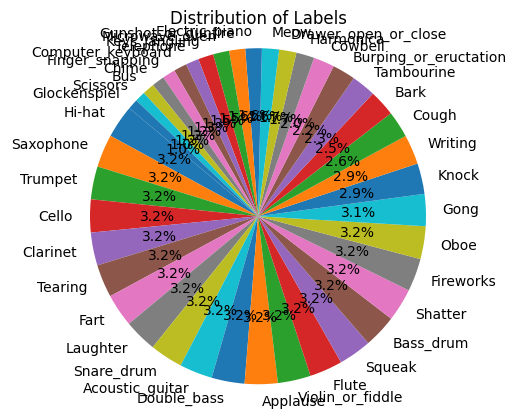

In [42]:
value_counts = meta_train.label.value_counts()
labels = value_counts.index
sizes = value_counts.values

# Plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

ax.axis('equal')

plt.title('Distribution of Labels')
plt.show()

In [43]:
meta_train.manually_verified.value_counts()

manually_verified
0    5763
1    3710
Name: count, dtype: int64

In [44]:
print(meta_train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


In [45]:
print('Minimum samples per category = ', min(meta_train.label.value_counts()))
print('Maximum samples per category = ', max(meta_train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


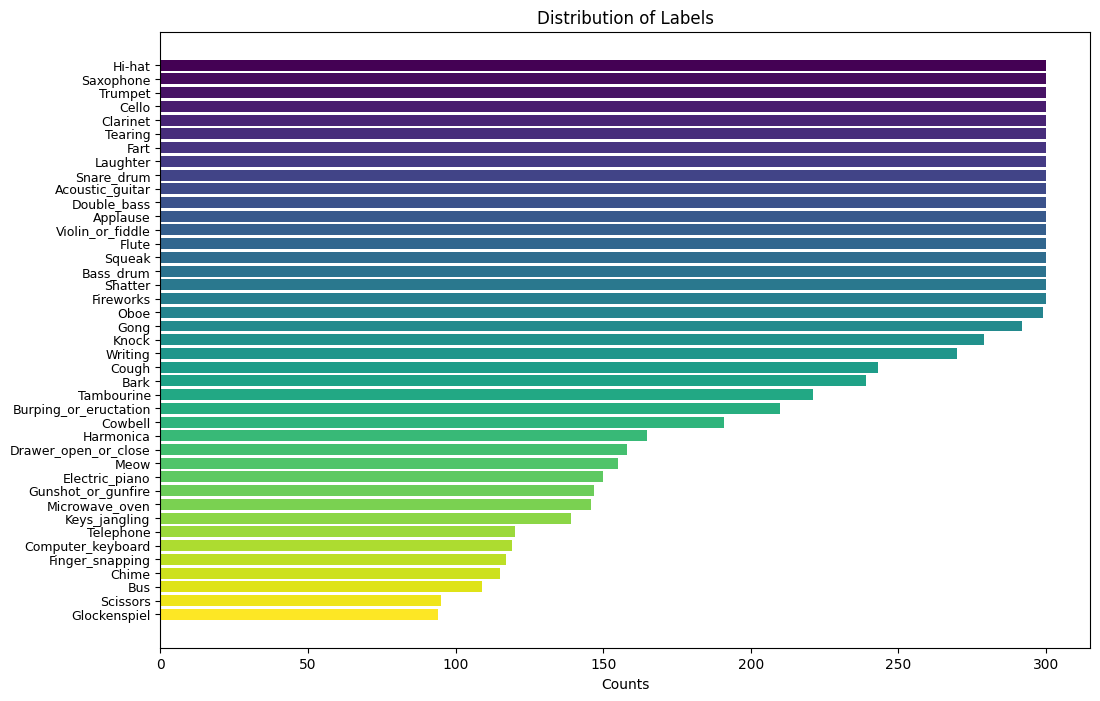

In [46]:

value_counts = meta_train.label.value_counts()

labels = value_counts.index
sizes = value_counts.values

# Generate a color array
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

# Plot
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size for better readability
bars = ax.barh(labels, sizes, color=colors)

# Add labels and title
ax.set_xlabel('Counts')
ax.set_title('Distribution of Labels')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=9)

# Invert y-axis to have the highest values on top
ax.invert_yaxis()

# Show plot
plt.show()


We observe that:

The number of audio samples per category is non-nform. The minimum number of audio samples in a category is 94 while the maximum is 300 Also, the proportion of maually_verified labels per category is non-uniform. ### Reading Audio Files The audios are Pulse-code modulated with a bit depth of 16 and a sampling rate of 44.1 kHz

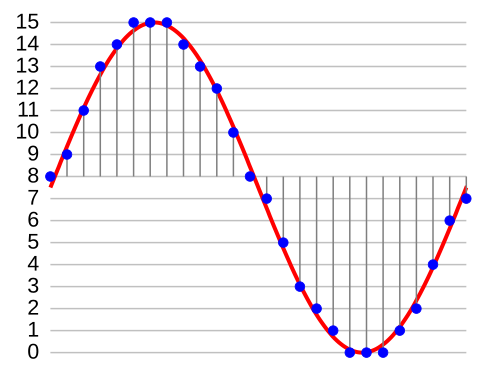

* Bit-depth = 16: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values
* Samplig rate = 44.1 kHz: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100*3.2 = 141120 values.

Let's listen to an audio file in our dataset.

In [47]:
import IPython.display as ipd  
fname = '/kaggle/input/freesound-audio-tagging/audio_train/34881c5f.wav'   
ipd.Audio(fname)

In [48]:
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  422478
Duration =  9.58


In [49]:
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (422478,)
[  1 109  84 ...  -1  -1   0]


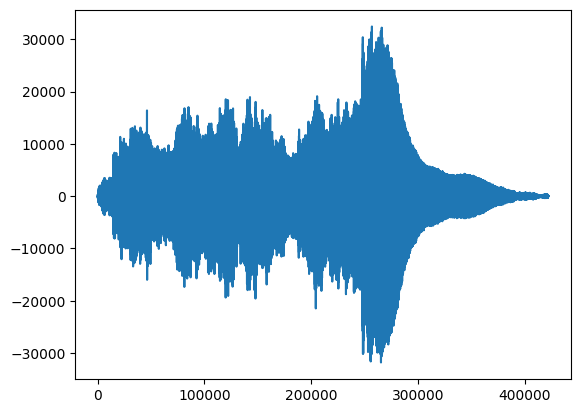

In [50]:
plt.plot(data)
plt.gca().lines[-1].set_linestyle('-')

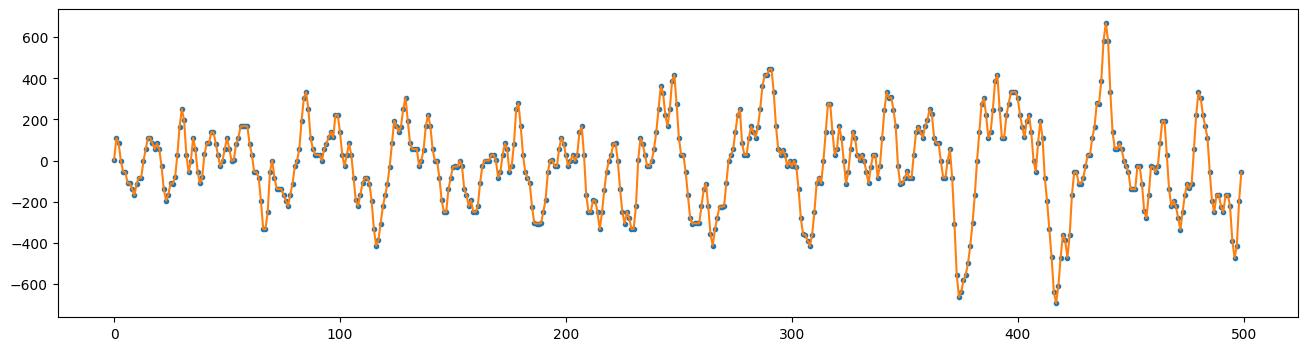

In [51]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

**Audio Length**

We shall now analyze the lengths of the audio files in our dataset

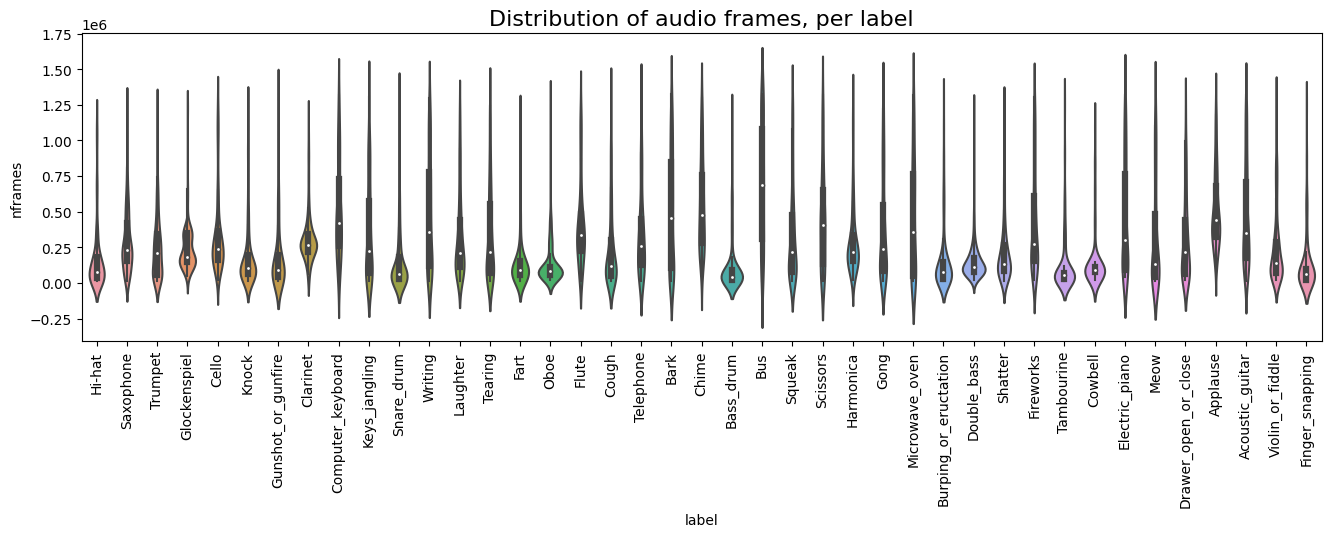

In [52]:
import seaborn as sns
train = meta_train 
train['nframes'] = meta_train['fname'].apply(lambda f: wave.open('/kaggle/input/freesound-audio-tagging/audio_train/' + f).getnframes())
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=meta_train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

We observe:

The distribution of audio length across labels is non-uniform and has high variance.

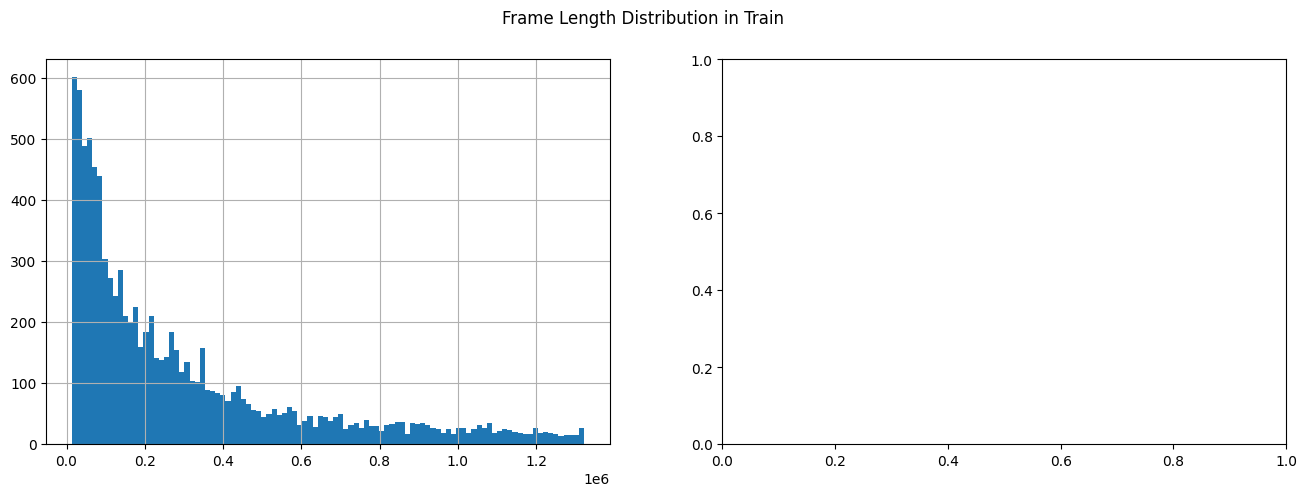

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])

plt.suptitle('Frame Length Distribution in Train ', ha='center', fontsize='large');

We observe:

Majority of the audio files are short. There are four abnormal length in the test histogram. Let's analyze them.

In [54]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    IPython.display.display(ipd.Audio( '/content/drive/MyDrive/internship/FSDKaggle2018.audio_test/' + fname))

NameError: name 'test' is not defined

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001,
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
          self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

DataGenerator Class¶ The DataGenerator class inherits from keras.utils.Sequence . It is useful for preprocessing and feeding the data to a Keras model.

Once initialized with a batch_size, it computes the number of batches in an epoch. The len method tells Keras how many batches to draw in each epoch. The getitem method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only X is returned. If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the on_epoch_end method. Note: Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None,
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    return self.__data_generation(list_IDs_temp)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID

            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)

            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X


Normalization¶ Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1].

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

**MFCC**

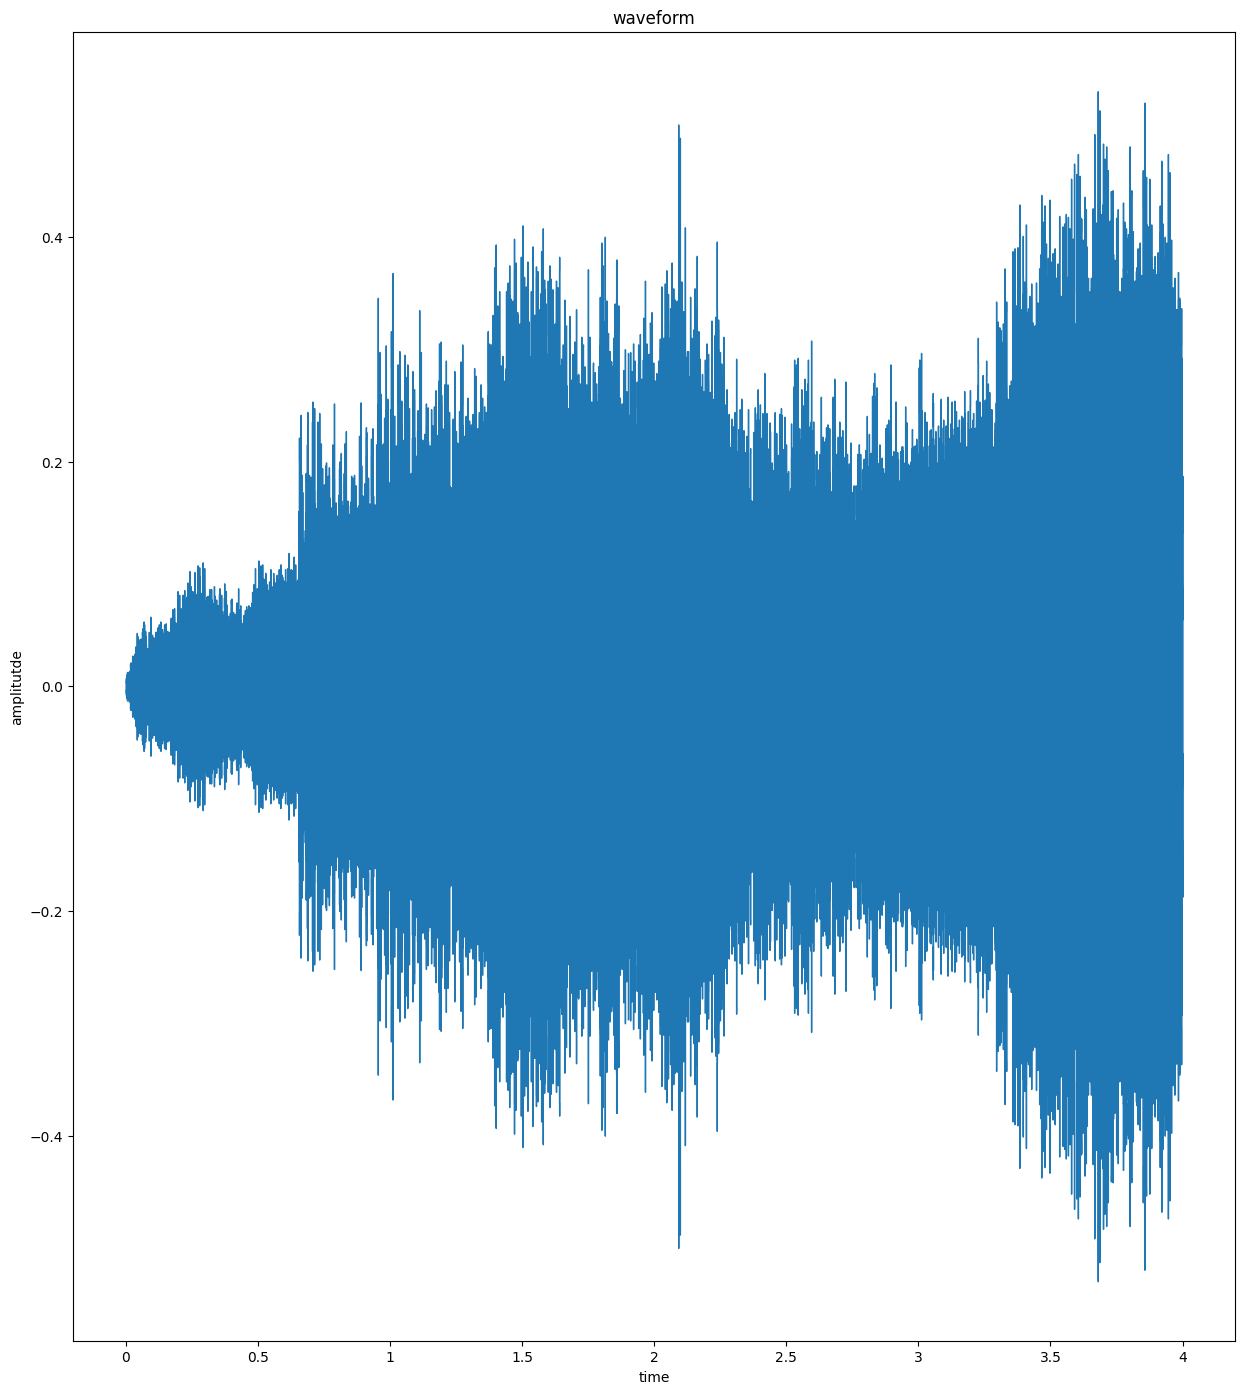

In [55]:
import librosa , librosa.display
SAMPLE_RATE = 44100
signal = '/kaggle/input/freesound-audio-tagging/audio_train/34881c5f.wav'
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]
plt.figure(figsize=(15,17))
librosa.display.waveshow(wav)
plt.title('waveform')
plt.xlabel('time')
plt.ylabel('amplitutde')
plt.show()

In [56]:
hop_length =512
n_fft = 8192

Text(0.5, 1.0, 'Spectrogram (dB)')

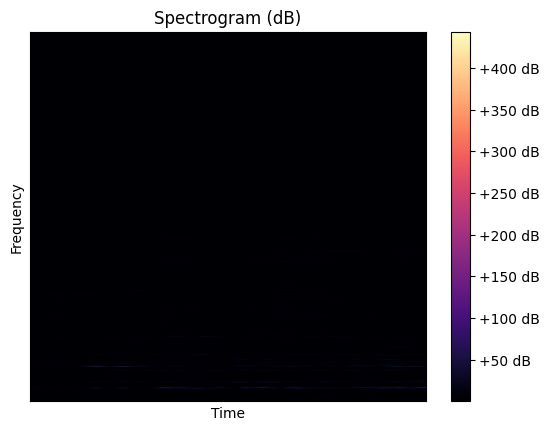

In [57]:
hop_length_duration = float(hop_length)/SAMPLE_RATE
n_fft_duration = float(n_fft)/SAMPLE_RATE
stf = librosa.stft(wav , n_fft = n_fft, hop_length = hop_length )
spectrogram = np.abs(stf)
librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [ ]:
MFCCS = librosa.feature.mfcc(y = wav, sr = sr, n_fft = n_fft, hop_length = hop_length)
librosa.display.specshow(MFCCS, sr= sr, hop_length = hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.title('MFCC')
plt.show()

Text(0.5, 1.0, 'Log_Spectrogram (dB)')

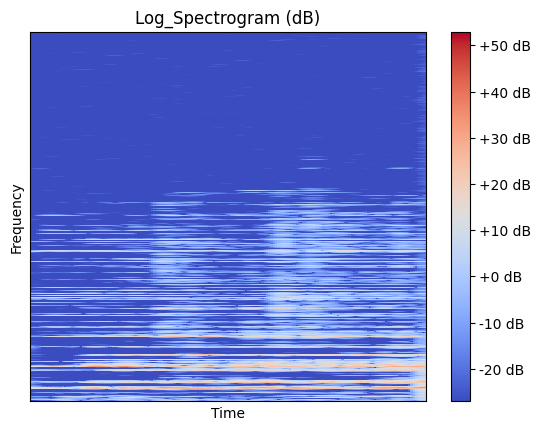

In [58]:
sr =SAMPLE_RATE
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Log_Spectrogram (dB)")

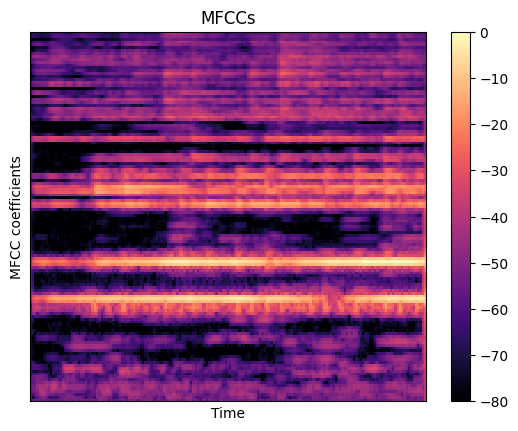

In [59]:
mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")


plt.show()

In [60]:
import os
import json
import librosa
import numpy as np
import pandas as pd

# Constants
SAMPLE_RATE = 22050  # Sample rate
N_MFCC = 50  # Number of MFCCs to extract
MAX_MFCC_VECTORS = 130  # Max number of MFCC vectors to pad/truncate to

def save_mfcc(csv_path, audio_folder_path, json_path, num_mfcc=N_MFCC, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.

    :param csv_path (str): Path to the CSV file containing metadata
    :param audio_folder_path (str): Path to the folder containing audio files
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # Dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    # Read the CSV file
    df = pd.read_csv(csv_path)
    print("CSV file read successfully!")

    # Loop through all rows in the CSV file
    for i, row in df.iterrows():
        file_path = os.path.join(audio_folder_path, row["fname"])
        label = row["label"]
        
        try:
            # Load audio file
            signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

            # Extract MFCC
            mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length).T

            # Pad or truncate MFCC to ensure uniform length
            if len(mfcc) > MAX_MFCC_VECTORS:
                mfcc = mfcc[:MAX_MFCC_VECTORS]
            elif len(mfcc) < MAX_MFCC_VECTORS:
                pad_width = MAX_MFCC_VECTORS - len(mfcc)
                mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')

            # Ensure all MFCC arrays have the same length
            assert mfcc.shape[0] == MAX_MFCC_VECTORS, f"MFCC shape mismatch: {mfcc.shape[0]} != {MAX_MFCC_VECTORS}"

            # Store MFCC feature and label
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(label)
            data["mapping"].append(row["label"])  # Store the label in mapping if needed

            print(f"Processed {file_path}")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Check if data was collected
    if not data["mfcc"] or not data["labels"]:
        print("No data was collected. Please check your dataset and preprocessing steps.")
        return

    # Save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("Data successfully saved to JSON file!")

if __name__ == "__main__":
    CSV_PATH = "/kaggle/input/freesound-audio-tagging/train.csv"  # Replace with your CSV path
    DATASET_PATH = "/kaggle/input/freesound-audio-tagging/audio_train"  # Replace with your dataset path
    JSON_PATH = "data.json" 
    save_mfcc(CSV_PATH, DATASET_PATH, JSON_PATH)


CSV file read successfully!
Processed /kaggle/input/freesound-audio-tagging/audio_train/00044347.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/001ca53d.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/002d256b.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/0033e230.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/00353774.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/003b91e8.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/003da8e5.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/0048fd00.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/004ad66f.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/0063ab88.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/006f2f32.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/0075d39c.wav
Processed /kaggle/input/freesound-audio-tagging/audio_train/00780200.wav
Processed /kaggle/input

In [62]:
DATA_PATH = "/kaggle/save/path_to_save_json.json"
def load_data(data_path):
    """Loads training dataset from JSON file.

    :param data_path (str): Path to JSON file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    return X, y
X, y = load_data('data.json')
 

Data successfully loaded!
Shape of X: (9473, 130, 50)
Shape of y: (9473,)


In [63]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [64]:
def preprocess_data(X, y):
    """Preprocesses the data for CNN input."""
    # Encode the string labels as integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Ensure labels are one-hot encoded
    y = to_categorical(y, num_classes=len(np.unique(y)))

    # Add a channel dimension to the features
    X = X[..., np.newaxis]

    return X, y, label_encoder
X, y, label_encoder = preprocess_data(X, y)


In [65]:
import tensorflow as tf

def model(input_shape, num_classes):
    """Builds a deeper CNN model for MFCC classification."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model




In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [67]:

input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
model = model(input_shape, num_classes)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,callbacks=[early_stopping, reduce_lr])


Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7018 - loss: 1.0342 - val_accuracy: 0.6470 - val_loss: 1.4925 - learning_rate: 1.2500e-04
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7077 - loss: 0.9657 - val_accuracy: 0.6501 - val_loss: 1.5084 - learning_rate: 1.2500e-04
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7156 - loss: 0.9471 - val_accuracy: 0.6475 - val_loss: 1.5378 - learning_rate: 1.2500e-04
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7177 - loss: 0.9354 - val_accuracy: 0.6517 - val_loss: 1.5156 - learning_rate: 1.2500e-04
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7261 - loss: 0.9129 - val_accuracy: 0.6475 - val_loss: 1.5488 - learning_rate: 1.2500e-04
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7263 - loss: 0.8868 - val_accuracy: 0.6533 - val_loss: 1.5306 - learning_rate: 1.2500e-04
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/ste

In [96]:

evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6468 - loss: 1.4876
Test Loss: 1.4925190210342407
Test Accuracy: 0.6469656825065613


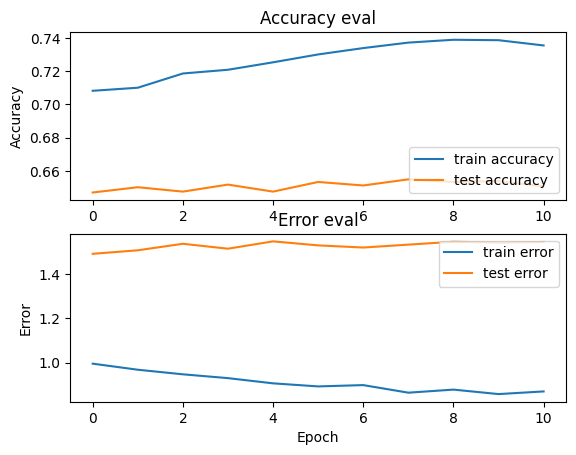

In [97]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
plot_history(history)